# Classification with oversampled data (SMOTE)

In [1]:
# import modules

import h5py
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support, classification_report, make_scorer
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, load_model
from keras.layers import Dense, LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# read in data

data = pd.read_csv(r"C:\Users\hien\Desktop\masterdata\creditcard.csv")

## Data preprocessing

In [3]:
# Split into training and test set
x = data.iloc[:,:-1]      # dataframe without class feature
y = data.iloc[:,-1]       # selecting only class feature

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print ("Training - fraud case: {:.2f}%".format(np.sum(y_train==1)/len(y_train)*100))
print ("Testing - fraud case: {:.2f}%".format(np.sum(y_test==1)/len(y_test)*100))
print ("# Fraud in training: ", np.sum(y_train==1))
print ("# Non-fraud in training: ", np.sum(y_train==0))
print ("# Fraud in test: ", np.sum(y_test==1))
print ("# Non-fraud in test: ", np.sum(y_test==0))


Training - fraud case: 0.17%
Testing - fraud case: 0.17%
# Fraud in training:  394
# Non-fraud in training:  227451
# Fraud in test:  98
# Non-fraud in test:  56864


In [4]:
#scaling amount and time to prevent data leakage

scale_amount = RobustScaler()
scale_time = RobustScaler()


scale_amount.fit(x_train.iloc[:,-1:])
x_train.iloc[:,-1:] = scale_amount.transform(x_train.iloc[:,-1:])
x_test.iloc[:,-1:]= scale_amount.transform(x_test.iloc[:,-1:])


scale_time.fit(x_train.iloc[:,0:1])
x_train.iloc[:,0:1] = scale_time.transform(x_train.iloc[:,0:1])
x_test.iloc[:,0:1] = scale_time.transform(x_test.iloc[:,0:1])


C:\Users\hien\anaconda\envs\new_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\hien\anaconda\envs\new_env\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
C:\Users\hien\anaconda\envs\new_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [5]:
# SMOTE is applied to sub-training set to prevent data leakage
# Split training set into sub-training set for SMOTE and validation set to prevent data leakage
x_subtrain, x_val, y_subtrain, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 39)

print ("# Fraud in training: ", np.sum(y_subtrain==1))
print ("# Non-fraud in training: ", np.sum(y_subtrain==0))
print ("# Fraud in validation: ", np.sum(y_val==1))
print ("# Non-fraud in validation: ", np.sum(y_val==0))


# Fraud in training:  313
# Non-fraud in training:  181963
# Fraud in validation:  81
# Non-fraud in validation:  45488


In [6]:
# Oversampling minority class using SMOTE
smote = SMOTE(random_state=42)
x_subtrain_smote, y_subtrain_smote = smote.fit_resample(x_subtrain, y_subtrain)
print ("Percentage of cases with class 1 for training:{:.4f}".format(np.sum(y_subtrain_smote==1)/len(y_subtrain_smote)))
print ("Percentage of cases with class 1 for test:{:.4f}".format(np.sum(y_test==1)/len(y_test)), "\n")

Percentage of cases with class 1 for training:0.5000
Percentage of cases with class 1 for test:0.0017 



In [7]:
print ("# Fraud in training: ", np.sum(y_subtrain_smote==1))
print ("# Non-fraud in training: ", np.sum(y_subtrain_smote==0))
print ("# Fraud in validation: ", np.sum(y_val==1))
print ("# Non-fraud in validation: ", np.sum(y_val==0))
print ("# Fraud in test: ", np.sum(y_test==1))
print ("# Non-fraud in test: ", np.sum(y_test==0))

# Fraud in training:  181963
# Non-fraud in training:  181963
# Fraud in validation:  81
# Non-fraud in validation:  45488
# Fraud in test:  98
# Non-fraud in test:  56864


## Model implementation

In [8]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc

## LightGBM

In [9]:
#Import LightGBM model
from lightgbm import LGBMClassifier

In [10]:
#Create a gbm Classifier
lgbm = LGBMClassifier()



In [11]:
#Train the model using the training sets
lgbm.fit(x_subtrain_smote, y_subtrain_smote)


LGBMClassifier()

In [12]:
#Predict the response for test dataset

y_pred_lgbm = lgbm.predict(x_test)

cm = confusion_matrix(y_test, y_pred_lgbm)
print ("Confusion matrix:\n", cm)
print ("\n")

precision, recall, _ = precision_recall_curve(y_test, y_pred_lgbm)

print ("accuracy: {:.2f}".format(accuracy_score(y_test, y_pred_lgbm)))
print ("precision: {:.2f}".format(precision_score(y_test, y_pred_lgbm)))
print ("recall: {:.2f}".format(recall_score(y_test, y_pred_lgbm)))
print ("f1 score: {:.2f}".format(f1_score(y_test, y_pred_lgbm)))
print ("Average precision: {:.2f}".format(average_precision_score(y_test, y_pred_lgbm)))
print ("AUC-ROC: {:.2f}".format(roc_auc_score(y_test, y_pred_lgbm)))

auc_score = auc(recall, precision)
print('Logistic PR AUC: %.3f' % auc_score)

Confusion matrix:
 [[56806    58]
 [   15    83]]


accuracy: 1.00
precision: 0.59
recall: 0.85
f1 score: 0.69
Average precision: 0.50
AUC-ROC: 0.92
Logistic PR AUC: 0.718


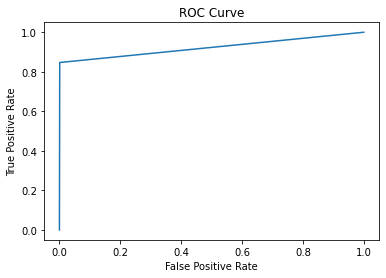

In [13]:
fpr, tpr, _ = roc_curve(y_test, y_pred_lgbm)
# plot the roc curve for the model

plt.plot(fpr, tpr)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
# show the legend
#plt.legend()
# show the plot
plt.show()

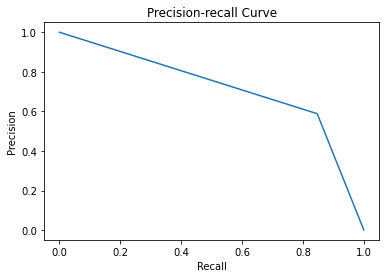

In [14]:
plt.plot(recall, precision)
plt.title("Precision-recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()